# Project 4: Gene regulatory Inferrence With GENIE3

#### Modules used for the project

In [202]:
from sklearn.tree import BaseDecisionTree
from sklearn.ensemble import *
from sklearn.metrics import *
from numpy import *
import time
from operator import itemgetter
from multiprocessing import Pool
import igraph
import os 
import re
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import *
import plotly
import plotly.graph_objects as go
import kaleido

#Packages Tested
from tqdm.autonotebook import tqdm
from grenadine.Inference.regression_predictors import *
from grenadine.Inference.inference import *
from grenadine.Preprocessing.standard_preprocessing import *
from sklearn.svm import SVR
import matplotlib.cm as cm


## I) GENIE3 Implementation and modification

### A) GENIE3 Algorithm

#### Computing feature importances in each regression problem 

In [203]:
def compute_feature_importances(estimator,tree_method):
    if isinstance(estimator, BaseDecisionTree):
        return estimator.tree_.compute_feature_importances(normalize=False)
    
    elif tree_method=='GB':
        return estimator.feature_importances_
    
    else:
        importances = [e.tree_.compute_feature_importances(normalize=False)
                       for e in estimator.estimators_]
        importances = asarray(importances)
        return sum(importances,axis=0) / len(estimator)

#### GENIE3 for a specific input gene

In [204]:
def GENIE3_single(expr_data,output_idx,input_idx,tree_method,K,ntrees,learning_rate='default',random_state=None):
    
    ngenes = expr_data.shape[1]
    
    # Expression of target gene
    output = expr_data[:,output_idx]
    
    # Normalize output data
    output = output / std(output)
    
    # Remove target gene from candidate regulators
    input_idx = input_idx[:]
    if output_idx in input_idx:
        input_idx.remove(output_idx)

    expr_data_input = expr_data[:,input_idx]
    
    # Parameter K of the tree-based method
    if (K == 'all') or (isinstance(K,int) and K >= len(input_idx)):
        max_features = "auto"
    else:
        max_features = K
    
    if tree_method == 'RF':
        treeEstimator = RandomForestRegressor(n_estimators=ntrees,max_features=max_features,
                                              random_state=random_state)    
    elif tree_method == 'ET':
        treeEstimator = ExtraTreesRegressor(n_estimators=ntrees,max_features=max_features,
                                            random_state=random_state) 
        
    elif tree_method == 'GB':
        
        if learning_rate=='default':
            treeEstimator = GradientBoostingRegressor(n_estimators=ntrees,max_features=max_features,
                                                      random_state=random_state)
        else :
            treeEstimator = GradientBoostingRegressor(n_estimators=ntrees,max_features=max_features,
                                                      learning_rate=learning_rate,random_state=random_state)  
    elif tree_method == 'AB':
        
        if learning_rate=='default':
            treeEstimator = AdaBoostRegressor(n_estimators=ntrees,random_state=random_state)
        else:
            treeEstimator = AdaBoostRegressor(n_estimators=ntrees,learning_rate=learning_rate,random_state=random_state)
        
    treeEstimator.fit(expr_data_input,output)
    """
    elif tree_method == 'GB' or tree_method == 'AB':
        label_enc = preprocessing.LabelEncoder()
        output = label_enc.fit_transform(output)
        estimator.fit(expr_data_input,output)
    """
    # Compute importance scores
    #if tree_method == "RF" or tree_method == "ET":
    feature_importances = compute_feature_importances(treeEstimator,tree_method)
    
    #elif tree_method = "GB" or tree_method = "AB":
    #    feature_importances = compute_feature_importances
    
    vi = zeros(ngenes)
    vi[input_idx] = feature_importances
       
    return vi

#### GENIE3 algorithm for every genes combination

In [205]:
def GENIE3(expr_data,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1,verbose=True,learning_rate='default',random_state=None):
    
    '''Computation of tree-based scores for all putative regulatory links.
    
    Parameters
    ----------
    
    expr_data: numpy array
        Array containing gene expression values. Each row corresponds to a condition and each column corresponds to a gene.
        
    gene_names: list of strings, optional
        List of length p, where p is the number of columns in expr_data, containing the names of the genes. The i-th item of gene_names must correspond to the i-th column of expr_data.
        default: None
        
    regulators: list of strings, optional
        List containing the names of the candidate regulators. When a list of regulators is provided, the names of all the genes must be provided (in gene_names). When regulators is set to 'all', any gene can be a candidate regulator.
        default: 'all'
        
    tree-method: 'RF' or 'ET', optional
        Specifies which tree-based procedure is used: either Random Forest ('RF') or Extra-Trees ('ET')
        default: 'RF'
        
    K: 'sqrt', 'all' or a positive integer, optional
        Specifies the number of selected attributes at each node of one tree: either the square root of the number of candidate regulators ('sqrt'), the total number of candidate regulators ('all'), or any positive integer.
        default: 'sqrt'
         
    ntrees: positive integer, optional
        Specifies the number of trees grown in an ensemble.
        default: 1000
    
    nthreads: positive integer, optional
        Number of threads used for parallel computing
        default: 1
        
        
    Returns
    -------

    An array in which the element (i,j) is the score of the edge directed from the i-th gene to the j-th gene. All diagonal elements are set to zero (auto-regulations are not considered). When a list of candidate regulators is provided, the scores of all the edges directed from a gene that is not a candidate regulator are set to zero.
        
    '''
    
    time_start = time.time()
    
    # Check input arguments
    if not isinstance(expr_data,ndarray):
        raise ValueError('expr_data must be an array in which each row corresponds to a condition/sample and each column corresponds to a gene')
        
    ngenes = expr_data.shape[1]
    
    if gene_names is not None:
        if not isinstance(gene_names,(list,tuple)):
            raise ValueError('input argument gene_names must be a list of gene names')
        elif len(gene_names) != ngenes:
            raise ValueError('input argument gene_names must be a list of length p, where p is the number of columns/genes in the expr_data')
        
    if regulators != 'all':
        if not isinstance(regulators,(list,tuple)):
            raise ValueError('input argument regulators must be a list of gene names')

        if gene_names is None:
            raise ValueError('the gene names must be specified (in input argument gene_names)')
        else:
            sIntersection = set(gene_names).intersection(set(regulators))
            if not sIntersection:
                raise ValueError('the genes must contain at least one candidate regulator')        
        
    if tree_method != 'RF' and tree_method != 'ET' and tree_method != 'GB' and tree_method != 'AB':
        raise ValueError('input argument tree_method must be "RF" (Random Forests) or "ET" (Extra-Trees)')
        
    if K != 'sqrt' and K != 'all' and not isinstance(K,int): 
        raise ValueError('input argument K must be "sqrt", "all" or a stricly positive integer')
        
    if isinstance(K,int) and K <= 0:
        raise ValueError('input argument K must be "sqrt", "all" or a stricly positive integer')
    
    if not isinstance(ntrees,int):
        raise ValueError('input argument ntrees must be a stricly positive integer')
    elif ntrees <= 0:
        raise ValueError('input argument ntrees must be a stricly positive integer')
        
    if not isinstance(nthreads,int):
        raise ValueError('input argument nthreads must be a stricly positive integer')
    elif nthreads <= 0:
        raise ValueError('input argument nthreads must be a stricly positive integer')
          
    print('Tree method: ' + str(tree_method))
    print('K: ' + str(K))
    print('Number of trees: ' + str(ntrees))
    print('\n')
        
    
    # Get the indices of the candidate regulators
    if regulators == 'all':
        input_idx = list(range(ngenes))
    else:
        input_idx = [i for i, gene in enumerate(gene_names) if gene in regulators]

    
    # Learn an ensemble of trees for each target gene, and compute scores for candidate regulators
    VIM = zeros((ngenes,ngenes))
    
    if nthreads > 1:
        if verbose==True:
            print('running jobs on %d threads' % nthreads)

        input_data = list()
        for i in range(ngenes):
            input_data.append( [expr_data,i,input_idx,tree_method,K,ntrees] )

        pool = Pool(nthreads)
        alloutput = pool.map(wr_GENIE3_single, input_data)
    
        for (i,vi) in alloutput:
            VIM[i,:] = vi

    else:
        if verbose==True:
            print('running single threaded jobs')
        for i in range(ngenes):
            if verbose==True:
                if i%10==0:
                    print('Gene %d/%d...' % (i+1,ngenes))
            
            vi = GENIE3_single(expr_data,i,input_idx,tree_method,K,ntrees,learning_rate,random_state)
            VIM[i,:] = vi

   
    VIM = transpose(VIM)
 
    time_end = time.time()
    if verbose==True:
        print("Elapsed time: %.2f seconds" % (time_end - time_start))

    return VIM

### B) Evaluation of the Algorithm with DREAM4 data

#### Parsing DREAM4 dataset and generating training data

In [168]:
def GetFilePaths(rootPath):
    filesList=[]
    for root, dirs, files in os.walk(rootPath):
        for file in files:
            indexFiles=file.endswith("indexes.tsv")
            steadyFiles=file.endswith("steadyState.tsv")
            timeFiles=file.endswith("timeSeries.tsv")
            tsvFiles=file.endswith(".tsv")
            if  tsvFiles and not indexFiles and not steadyFiles and not timeFiles:
                filesList.append(os.path.join(root, file))
    return filesList

def WriteValues(rootPath):
    
    files=GetFilePaths(rootPath)
    fluxWriteSteady=open(rootPath+'steadyState.tsv','w')
    flagHeaderSteady=0
    regexHeaderSteady=".*G.*"
    
    fluxWriteTime=open(rootPath+'timeSeries.tsv','w')   
    
    for file in files:
        
        fluxRead=open(file,'r')
        lines=fluxRead.readlines()
        
        
        
        if file.endswith("timeseries.tsv"):
            for line in lines:
                fluxWriteTime.write(line)        
            
        else :
            
            if lines and flagHeaderSteady==0:
                if(re.match(regexHeaderSteady,lines[0])):
                    flagHeaderSteady=1
                    fluxWriteSteady.write(re.match(regexHeaderSteady,lines[0]).group(0)+'\n')
                    
            if flagHeaderSteady==1:
                lines=lines[1:]
            for line in lines:
                fluxWriteSteady.write(line)
                
        fluxRead.close()
        
    fluxWriteSteady.close()
    fluxWriteTime.close()

#### Reading the true Networks 

In [6]:
def ReadGoldStandard(path):
    flux=open(path,'r')
    lignes=flux.readlines()
    connexionList=[]
    for ligne in lignes:
        listeTemp=ligne.split('\n')[0].split('\t')
        connexionList.append([int(listeTemp[0][1:]),int(listeTemp[1][1:]),int(listeTemp[2])])
    connexionList=array(connexionList)
    nbOfVariables=max(connexionList[:,0])
    correctionMatrix=zeros((nbOfVariables,nbOfVariables))
    for connexion in connexionList:
        correctionMatrix[connexion[0]-1,connexion[1]-1]=connexion[2]
    return correctionMatrix

#### Computing score from training files and true networks

In [79]:
def ScoresFromSteadyFile(steadyFilePath,trueNetworkFilePath,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1,verbose=True):
    
    """
    Calculate the AUPR and AUROC scores directly from:
    -The SteadyState files (training data) 
    -The Goldstandard files(correction)
    
    Returns the AUPR and AUROC score
    """
    
    #Loading the files
    data=loadtxt(steadyFilePath,skiprows=1)
    corrMatrix=ReadGoldStandard(trueNetworkFilePath)
    
    #Creating the inferred connetion matrix
    inferedMatrix=GENIE3(data,gene_names=None,regulators='all',tree_method=tree_method,K='sqrt',ntrees=1000,nthreads=1,verbose=verbose)

    #Calculating the PR curve
    precision,recall,treshold=precision_recall_curve(corrMatrix.flatten(),inferedMatrix.flatten())

    #Calculating the ROC curve
    fpr,tpr,tresholds=roc_curve(corrMatrix.flatten(),inferedMatrix.flatten())
    
    #Calculating the Area under the curve for PR
    AUPR=auc(recall,precision)
    #Calculating the areau under the curve for ROC
    AUROC=auc(fpr,tpr)

    return [recall,precision],[fpr,tpr]

#### Writing the results on file

Since computation is really time consuming, we chose to write the results of the evaluation of GENIE3 algorithm in a separate folder: generated_data

###### Setting paths, row names and column names

In [169]:
#Generating the training data
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_1/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_2/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_3/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_4/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_5/')

#Correction file paths
gold_1='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_1.tsv'
gold_2='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_2.tsv'
gold_3='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_3.tsv'
gold_4='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_4.tsv'
gold_5='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_5.tsv'

#Training data paths
data_1='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_1_multifactorial.tsv'
data_2='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_2_multifactorial.tsv'
data_3='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_3_multifactorial.tsv'
data_4='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_4_multifactorial.tsv'
data_5='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_5_multifactorial.tsv'

#Search methods
searchMethods=["ET","RF","AB","GB"]
#Networks names
NETnames=["NET1","NET2","NET3","NET4","NET5"]

#Data Paths
dataPaths=[data_1,data_2,data_3,data_4,data_5]
#Correction Paths
corrPaths=[gold_1,gold_2,gold_3,gold_4,gold_5]

#OUTPUT Folder
pathGenerated='../../generated_data/Part1/'

#### Computing the reults and writing them

<span style="color:red"> Warning:</span> This part is time comsuming and the Results are already generated, running this cell is unnecessary

In [90]:
#Scores by methods (first Axis) and paths (second Axis)
scoreAUPR=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]
scoreAUROC=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]

#ROC and PR values by methods (first Axis) and paths (second Axis)
valuesPR=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]
valuesROC=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]

for i in range(len(searchMethods)):
    for j in range(len(dataPaths)):
        valuesPR[i][j],valuesROC[i][j]=ScoresFromSteadyFile(dataPaths[j],
                                                            corrPaths[j],
                                                            tree_method=searchMethods[i],
                                                            verbose=False)
        
for i in range(len(searchMethods)):
    for j in range(len(dataPaths)):
        method=searchMethods[i]
        dataset=dataPaths[j]
        nomFiROC=pathGenerated+method+'_'+'NET_'+str(j+1)+'_ROC.txt'
        nomFiPR=pathGenerated+method+'_'+'NET_'+str(j+1)+'_PR.txt'
        savetxt(nomFiROC,array(valuesROC[i][j]),delimiter=',')
        savetxt(nomFiPR,array(valuesPR[i][j]),delimiter=',')

Tree method: ET
K: sqrt
Number of trees: 1000


0.7518565387177969
Tree method: ET
K: sqrt
Number of trees: 1000


0.7284006294895509
Tree method: ET
K: sqrt
Number of trees: 1000


0.7865955360294982
Tree method: ET
K: sqrt
Number of trees: 1000


0.7927396018066512
Tree method: ET
K: sqrt
Number of trees: 1000


0.7973225215572466
Tree method: RF
K: sqrt
Number of trees: 1000


0.7486477920491561
Tree method: RF
K: sqrt
Number of trees: 1000


0.7227803635833459
Tree method: RF
K: sqrt
Number of trees: 1000


0.776349063141516
Tree method: RF
K: sqrt
Number of trees: 1000


0.7910683187773877
Tree method: RF
K: sqrt
Number of trees: 1000


0.7977562817296093
Tree method: AB
K: sqrt
Number of trees: 1000


0.7331014491412498
Tree method: AB
K: sqrt
Number of trees: 1000


0.6757622223073403
Tree method: AB
K: sqrt
Number of trees: 1000


0.756726421632082
Tree method: AB
K: sqrt
Number of trees: 1000


0.7661380241580766
Tree method: AB
K: sqrt
Number of trees: 1000


0.75532439290746

#### Parsing the results from files

In [9]:
#Scores by methods (first Axis) and paths (second Axis)
scoreAUPRFromFile=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]
scoreAUROCFromFile=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]

#ROC and PR values by methods (first Axis) and paths (second Axis)
valuesPRFromFile=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]
valuesROCFromFile=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]

for i in range(len(searchMethods)):
    for j in range(len(dataPaths)):
        method=searchMethods[i]
        dataset=dataPaths[j]
        nomFiROC=pathGenerated+method+'_'+'NET_'+str(j+1)+'_ROC.txt'
        nomFiPR=pathGenerated+method+'_'+'NET_'+str(j+1)+'_PR.txt'
        valuesROCFromFile[i][j]=loadtxt(nomFiROC,delimiter=',')
        valuesPRFromFile[i][j]=loadtxt(nomFiPR,delimiter=',')

### C) Presenting the Results

In [10]:
#Figures files destination
figPathPart1='../../figures/I-GENIEModifs/'

#### ROC Results

Area under curve values depending on the DREAM4 network

In [11]:
scoresROCFromFile=array([[ auc(valuesROCFromFile[j][i][0,:],valuesROCFromFile[j][i][1,:]) for i in range(len(dataPaths))] for j in range(len(searchMethods))])
tableROCScore=pd.DataFrame(scoresROCFromFile,index=searchMethods,columns=NETnames)

display(tableROCScore)

,NET1,NET2,NET3,NET4,NET5
ET,0.751857,0.728401,0.786596,0.792740,0.797323
RF,0.748648,0.722780,0.776349,0.791068,0.797756
AB,0.733101,0.675762,0.756726,0.766138,0.755324
GB,0.699632,0.663569,0.744826,0.760662,0.731021


Curve values depending on the DREAM4 Network

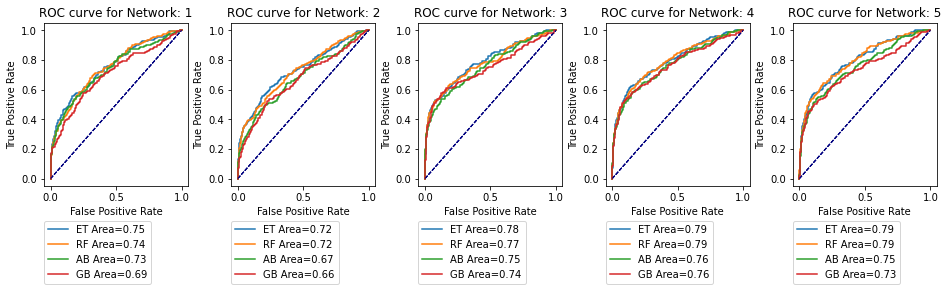

In [12]:
#Creating Figure
fig,axs=plt.subplots(1,len(NETnames),figsize=(16,3))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

#Filling the subplots
for i in range(len(searchMethods)):
    for j in range(len(NETnames)):
        axs[j].plot(valuesROCFromFile[i][j][0,:],
                    valuesROCFromFile[i][j][1,:],
                    label=searchMethods[i]+' Area='+str(tableROCScore.iloc[i,j])[0:4])
        axs[j].set_title('ROC curve for Network: '+str(j+1))
        axs[j].set_ylabel("True Positive Rate")
        axs[j].set_xlabel("False Positive Rate")
        axs[j].legend(loc=(0, -.6), prop=dict(size=10))
        axs[j].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        
fig.savefig(figPathPart1+'ROC_Curve_5NET.jpg', dpi=300, bbox_inches='tight')

#### PR Results

Area under curve values depending on the DREAM4 network

In [13]:
scoresPRFromFile=array([[ auc(valuesPRFromFile[j][i][0,:],valuesPRFromFile[j][i][1,:]) for i in range(len(dataPaths))] for j in range(len(searchMethods))])
tablePRScore=pd.DataFrame(scoresPRFromFile,index=searchMethods,columns=NETnames)

display(tablePRScore)

,NET1,NET2,NET3,NET4,NET5
ET,0.137174,0.154357,0.220164,0.190827,0.174472
RF,0.153808,0.152742,0.218177,0.208720,0.195291
AB,0.118425,0.127231,0.207292,0.202043,0.139994
GB,0.117907,0.094273,0.184419,0.170073,0.133148


Curve values depending on the DREAM4 Network

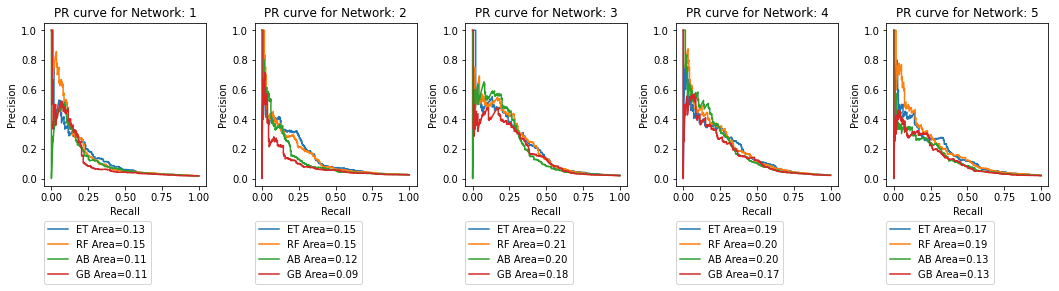

In [14]:
#Creating Figure
fig,axs=plt.subplots(1,len(NETnames),figsize=(18,3))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

#Filling the subplots
for i in range(len(searchMethods)):
    for j in range(len(NETnames)):
        axs[j].plot(valuesPRFromFile[i][j][0,:],
                    valuesPRFromFile[i][j][1,:],
                    label=searchMethods[i]+' Area='+str(tablePRScore.iloc[i,j])[0:4])
        axs[j].set_title('PR curve for Network: '+str(j+1))
        axs[j].set_ylabel("Precision")
        axs[j].set_xlabel("Recall")
        axs[j].legend(loc=(0, -.6), prop=dict(size=10))
        
fig.savefig(figPathPart1+'PR_Curve_5NET.jpg', dpi=300, bbox_inches='tight')

## II) Optimizing parameters for GENIE3

In [161]:
def ScoresFromSteadyFileParameters(steadyFilePath,trueNetworkFilePath,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1,verbose=True,learning_rate='default',random_state=None):
    
    """
    Calculate the AUPR and AUROC scores directly from:
    -The SteadyState files (training data) 
    -The Goldstandard files(correction)
    
    Returns the AUPR and AUROC score
    """
    
    #Loading the files
    data=loadtxt(steadyFilePath,skiprows=1)
    corrMatrix=ReadGoldStandard(trueNetworkFilePath)
    
    #Creating the inferred connetion matrix
    inferedMatrix=GENIE3(data,gene_names=None,regulators='all',tree_method=tree_method,K='sqrt',ntrees=1000,nthreads=1,verbose=verbose,learning_rate=learning_rate,random_state=random_state)

    #Calculating the PR curve
    precision,recall,treshold=precision_recall_curve(corrMatrix.flatten(),inferedMatrix.flatten())

    #Calculating the ROC curve
    fpr,tpr,tresholds=roc_curve(corrMatrix.flatten(),inferedMatrix.flatten())
    
    #Calculating the Area under the curve for PR
    AUPR=auc(recall,precision)
    #Calculating the areau under the curve for ROC
    AUROC=auc(fpr,tpr)

    return [recall,precision],[fpr,tpr]

In [174]:
def ComputeAUROCAUPR(steadyFilePath,trueNetworkFilePath,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1,verbose=True,learning_rate='default',random_state=None):
    PR,ROC=ScoresFromSteadyFileParameters(steadyFilePath,
                                   trueNetworkFilePath,
                                   gene_names,regulators,
                                   tree_method,K,ntrees,
                                   nthreads,
                                   verbose,
                                   learning_rate,
                                   random_state)
    AUPR  = auc(PR[0] , PR[1] )
    AUROC = auc(ROC[0], ROC[1])
    return AUPR,AUROC

##### Selection of the Network for evaluation and Parameters for the exploration

In [192]:
#Parameters of exploration:

#Seed 
seed=69

#nTrees:
minTrees=500
maxTrees=1000
stepTrees=500
treesParameter=np.arange(minTrees,maxTrees,stepTrees)

#learning rate
minRate=10*-3
maxRate=10*1
nbValues=2
learningParameter=np.logspace(minRate,maxRate,nbValues)

#K -> max_features
kExplore=['all','sqrt']

#Network of choice
netPath=data_1

#Correction  path
corrPath=gold_1

#Search methods
searchMethods=["ET","RF","AB","GB"]

# AUC ROC Score Matrix
AUROCXploreET=np.zeros( ( len(treesParameter)                          , len(kExplore) ) )
AUROCXploreRF=np.zeros( ( len(treesParameter)                          , len(kExplore) ) )
AUROCXploreAB=np.zeros( ( len(treesParameter) , len(learningParameter)                 ) )
AUROCXploreGB=np.zeros( ( len(treesParameter) , len(learningParameter) , len(kExplore) ) )

# AUC PR Score Matrix
AUPRXploreET=np.zeros( ( len(treesParameter)                           , len(kExplore) ) )
AUPRXploreRF=np.zeros( ( len(treesParameter)                           , len(kExplore) ) )
AUPRXploreAB=np.zeros( ( len(treesParameter)  , len(learningParameter)                 ) )
AUPRXploreGB=np.zeros( ( len(treesParameter)  , len(learningParameter) , len(kExplore) ) )


#OUTPUT Folder
pathGenerated='../../generated_data/Part2/'

#### Computing the results and writing them

<span style="color:red"> Warning:</span> This part is time consuming and the Results are already generated, running this cell is unnecessary

In [206]:
for i in range(len(treesParameter)): 
    
    #Exploration for ET and RF:
    for j in range(len(kExplore)):
        
        AUROCXploreET[i,j],AUPRXploreET[i,j] = ComputeAUROCAUPR(netPath,
                                                                corrPath,
                                                                gene_names=None,
                                                                regulators='all',
                                                                tree_method='ET',
                                                                K=kExplore[j],
                                                                ntrees=i,
                                                                nthreads=1,
                                                                verbose=False,
                                                                learning_rate='default',
                                                                random_state=seed)
        
        AUROCXploreRF[i,j],AUPRXploreRF[i,j] = ComputeAUROCAUPR(netPath,
                                                                corrPath,
                                                                gene_names=None,
                                                                regulators='all',
                                                                tree_method='RF',
                                                                K=kExplore[j],
                                                                ntrees=i,
                                                                nthreads=1,
                                                                verbose=False,
                                                                learning_rate='default',
                                                                random_state=seed) 
        #Exploration for GB
        for k in range(len(learningParameter)):
            
            AUROCXploreGB[i,k,j],AUPRXploreGB[i,k,j] = ComputeAUROCAUPR(netPath,
                                                                        corrPath,
                                                                        gene_names=None,
                                                                        regulators='all',
                                                                        tree_method='GB',
                                                                        K=kExplore[j],
                                                                        ntrees=i,
                                                                        nthreads=1,
                                                                        verbose=False,
                                                                        learning_rate=learningParameter[k],
                                                                        random_state=seed) 
    #Exploration for AB   
    for j in range(len(learningParameter)):   
        
        AUROCXploreAB[i,j],AUPRXploreAB[i,j] = ComputeAUROCAUPR(netPath,
                                                                corrPath,
                                                                gene_names=None,
                                                                regulators='all',
                                                                tree_method='AB',
                                                                K='all',
                                                                ntrees=i,
                                                                nthreads=1,
                                                                verbose=False,
                                                                learning_rate=learningParameter[j],
                                                                random_state=seed) 
        
#Reshaping the matrices to write them down
AUROCXploreET_reshaped = AUROCXploreET.reshape(len(treesParameter))
AUPRXploreET_reshaped = AUPRXploreET.reshape(len(treesParameter))
 
AUROCXploreRF_reshaped = AUROCXploreRF.reshape(len(treesParameter))
AUPRXploreRF_reshaped = AUPRXploreERF.reshape(len(treesParameter))

AUROCXploreAB_reshaped = AUROCXploreAB.reshape(len(treesParameter))
AUPRXploreAB_reshaped = AUPRXploreRA.reshape(len(treesParameter))
 
AUROCXploreGB_reshaped = AUROCXploreGB.reshape(len(treesParameter))
AUPRXploreGB_reshaped = AUPRXploreGB.reshape(len(treesParameter))

#Writing the files
savetxt(pathGenerated+'Xplore_AUPR_ET.txt',AUPRXploreET_reshaped,delimiter=',')
savetxt(pathGenerated+'Xplore_AUROC_ET.txt',AUROCXploreET_reshaped,delimiter=',')
savetxt(pathGenerated+'Xplore_AUPR_RF.txt',AUPRXploreRF_reshaped,delimiter=',')
savetxt(pathGenerated+'Xplore_AUROC_RF.txt',AUROCXploreRF_reshaped,delimiter=',')
savetxt(pathGenerated+'Xplore_AUPR_AB.txt',AUPRXploreAB_reshaped,delimiter=',')
savetxt(pathGenerated+'Xplore_AUROC_AB.txt',AUROCXploreAB_reshaped,delimiter=',')
savetxt(pathGenerated+'Xplore_AUPR_GB.txt',AUPRXploreGB_reshaped,delimiter=',')
savetxt(pathGenerated+'Xplore_AUROC_GB.txt',AUROCXploreGB_reshaped,delimiter=',')

Tree method: ET
K: sqrt
Number of trees: 1000


Tree method: RF
K: sqrt
Number of trees: 1000


Tree method: GB
K: sqrt
Number of trees: 1000


Tree method: GB
K: sqrt
Number of trees: 1000




/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:211: RuntimeWarning:

overflow encountered in square

/home/adrien/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb_

KeyboardInterrupt: 

## III) Other algorithms against GENIE3

Some functions might seem redundant, and the coding style is different; but the context didn't allow us to coordinate as much as we would have liked to

### A) Functions Definitions

##### Plots ROC and PR curves given the results

In [15]:
def ROC_plot(result,label,ax,color):
    fpr, tpr, _ = roc_curve(result["IS_REGULATED"], result["score"])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=color,
         lw=2, label='ROC curve of '+label+' (area = %0.2f)' % roc_auc)
    return roc_auc

def PR_plot(result,label,ax,color):
    precision, recall, _ = precision_recall_curve(result["IS_REGULATED"], result["score"])
    average_precision = average_precision_score(result["IS_REGULATED"], result["score"])
    ax.plot(recall, precision, color=color, lw=2,
          label='Precision-Recall curve of '+label+' (area = %0.2f)' % average_precision)
    return average_precision

##### Infer GRN from correction file

In [83]:
def goldSTD_(path):
    grn = pd.read_csv(path,sep="\t",header=None)

    grn.columns = ["TF","TG","IS_REGULATED"]
    grn.index = grn["TF"]+"_"+grn["TG"]

    grn = grn.drop_duplicates()
    return grn

##### Loads the training file and normalizes it

In [72]:
def LoadData(pathFile):
    X= pd.read_csv(pathFile,sep="\t")
    X = X.T
    X = z_score(X,axis=1)
    return X

##### Plots ROC and PR curve for every method for a given Network

In [128]:
def PR_ROC_Plotter(score_matrix_table, index_fig, grn,labels,outputPath):
    ROC_auc_table = []
    PR_auc_table = []
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    lw = 2

    colors = cm.rainbow(np.linspace(0,1,len(labels)))

    for i in range(len(labels)):
        score_matrix = score_matrix_table[i]
        ranking = rank_GRN(score_matrix)
        result = pd.concat([grn, ranking], axis=1)
        result = result.dropna()
        ROC_auc = ROC_plot(result, labels[i], ax1, colors[i])
        PR_auc = PR_plot(result, labels[i], ax2, colors[i])
        ROC_auc_table.append(ROC_auc)
        PR_auc_table.append(PR_auc)

    ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver operating characteristic example')
    ax1.legend(loc=(0, -.4), prop=dict(size=10))

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Extension of Precision-Recall curve to multi-class')
    ax2.legend(loc=(0, -.4), prop=dict(size=10))

    f.savefig(outputPath+'ROC_PR_Curve'+str(index_fig)+'.jpg', dpi=300, bbox_inches='tight')
    return ROC_auc_table, PR_auc_table

In [197]:
def BarPlot(df,title_,outputPath,typeOfPlot):
    fig = go.Figure()
    for j in df.columns:
        fig.add_trace(go.Bar(name=j, x=df.index, y=df[j],text = np.round(df[j],3),
                      textposition='auto'))


    fig.update_layout(barmode='group')
    fig.update_layout(
      title=title_,
      yaxis_title="Area under the curve (AUC)",
      #legend_title="Models Name",
      font=dict(
          family="Arial",
          size=18,
          color="Black"
      )
    )
    #fig.write_image(outputPath+typeOfPlot+"BarPlot.jpg",engine=kaleido)
    fig.show()

### B) Computation of all the files

##### Gathering the data

In [179]:
#DREAM data
X_tot = [LoadData(i) for i in dataPaths]

#Network names
NETlist=["NET1","NET2","NET3","NET4","NET5"]

#Grenadine Methods we will test, and their names
methodNames = ['GENIE3', 'AdaBoost'        , 'BayesianRidgeScore', 'TIGRESS', 'XGENIE3', 'GRNBoost2']
methodList  = [ GENIE3 , AdaBoost_regressor,  BayesianRidgeScore,   TIGRESS ,  XGENIE3 ,  GRNBoost2]

#Gene Names
f = open(dataPaths[0])
gene_names = f.readline()
gene_names = gene_names.rstrip('\n').split('\t')
gene_names = ' '.join(gene_names).replace('"','').split()
f.close()

#Links Matrix
scoreMatrix= [[[] for j in range(len(methodNames))] for i in range(len(NETlist)) ]
#Correction GRN
grnList=[goldSTD_(corrPaths[i]) for i in range(len(corrPaths))]

#OUTPUT path
pathGenerated='../../generated_data/Part3/'

#### Computing the results and writing them

<span style="color:red"> Warning:</span> This part is time consuming and the Results are already generated, running this cell is unnecessary

In [100]:
index_fig=1
roc_df = pd.DataFrame(columns=methodNames)
pr_df = pd.DataFrame(columns=methodNames)

#print(gene_names)
for i in range(len(NETlist)):
    grn = goldSTD_(corrPaths[i])
    
    for j in range(len(methodList)):
        print("Processing: " + NETlist[i])
        print("Method: " + methodNames[j])
        print("\n")
        scoreMatrix[i][j] = score_links(X_tot[i], methodList[j], gene_names)
        
        method=methodNames[j]
        nomFi=pathGenerated+method+'_'+'NET_'+str(i+1)+'.csv'
        scoreMatrix[i][j].to_csv(nomFi,sep=',')
    


Processing: NET1
Method: GENIE3


Processing: NET1
Method: AdaBoost


Processing: NET1
Method: BayesianRidgeScore


Processing: NET1
Method: TIGRESS


Processing: NET1
Method: XGENIE3


Processing: NET1
Method: GRNBoost2


Processing: NET2
Method: GENIE3


Processing: NET2
Method: AdaBoost




KeyboardInterrupt: 

### C) Presentation of the results

In [178]:
#Figures files destination
figPathPart3='../../figures/III-GENIEvsOther/'

#### Parsing the results from files

In [111]:
#Links Matrix From File
scoreMatrixFromFile= [[[] for j in range(len(methodNames))] for i in range(len(NETlist)) ]

#Filling the matrix
for i in range(len(NETlist)):
    for j in range(len(methodNames)):
        
        method=methodNames[j]
        nomFi=pathGenerated+method+'_'+'NET_'+str(i+1)+'.csv'
        scoreMatrixFromFile[i][j]=pd.read_csv(nomFi,sep=',',index_col=0)
        

##### Plotting the curves from the score matrices

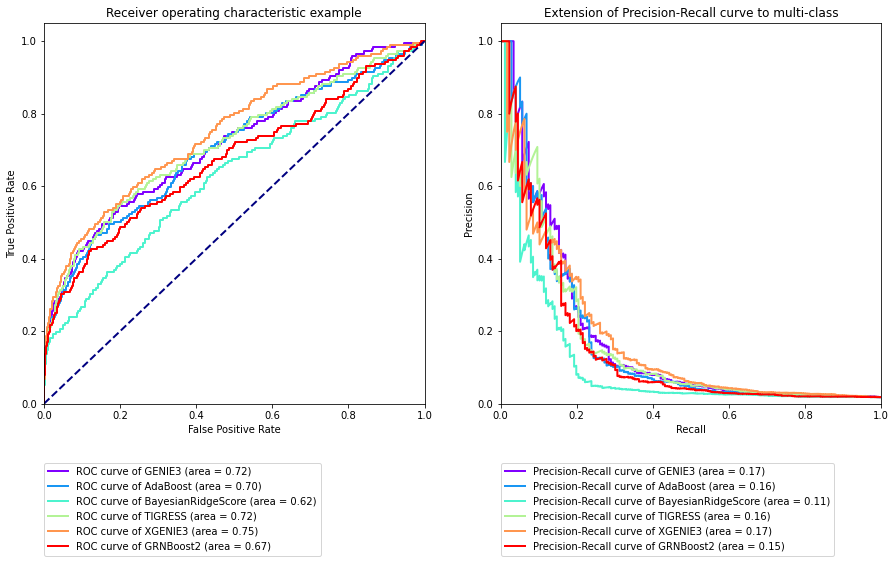

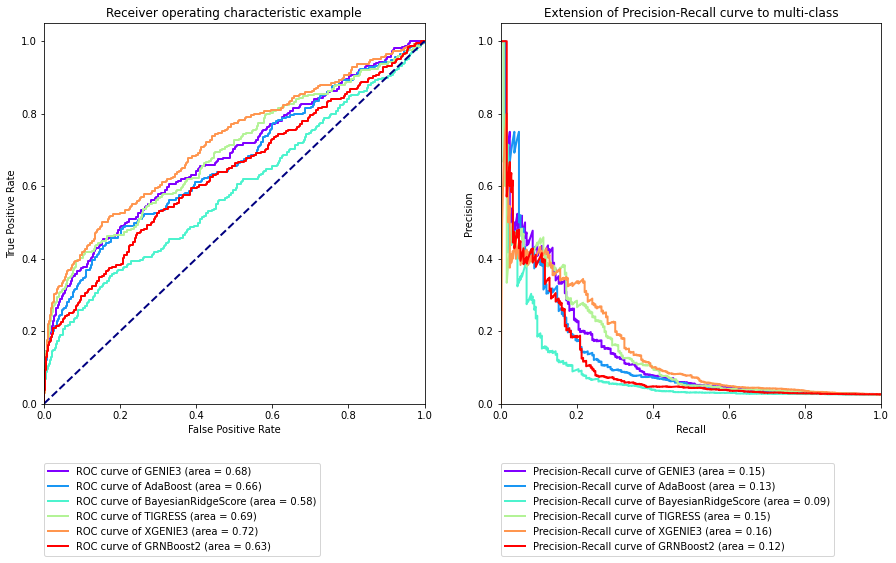

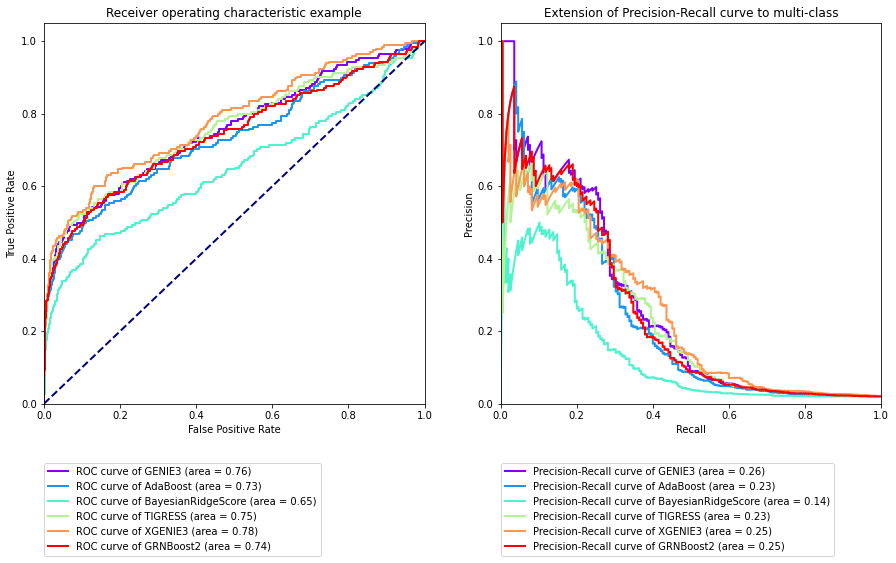

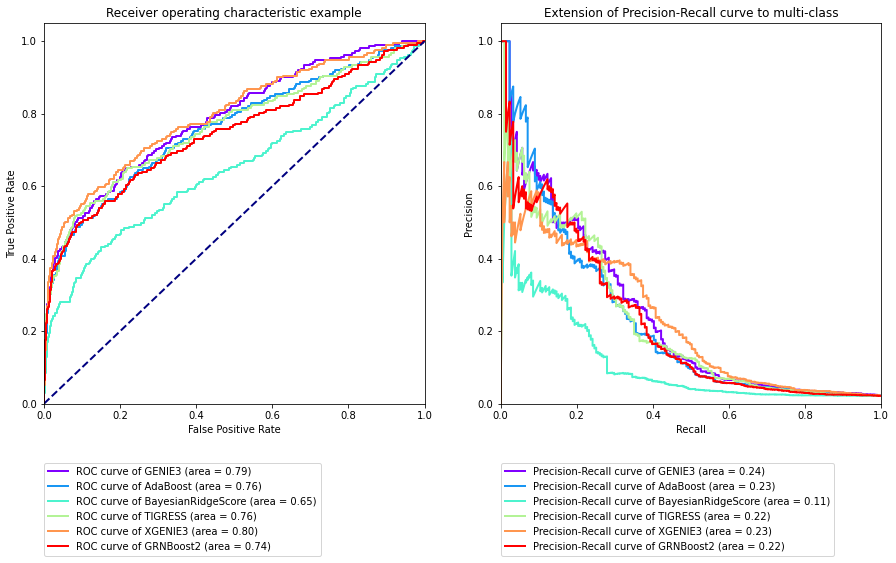

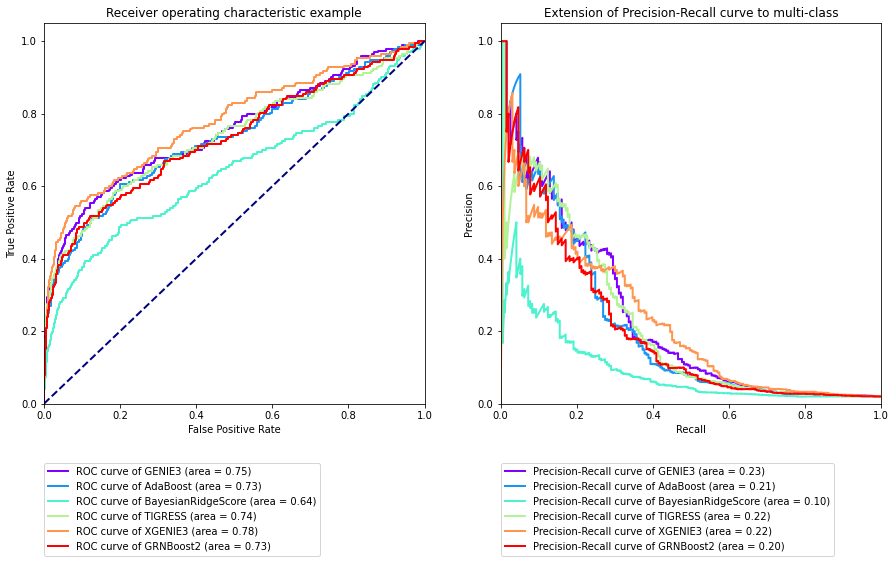

In [134]:
roc_df = pd.DataFrame(columns=methodNames)
pr_df = pd.DataFrame(columns=methodNames)

for i in range(len(X_tot)):

    ROC_auc_table, PR_auc_table = PR_ROC_Plotter(scoreMatrixFromFile[i],
                                                 i+1, 
                                                 grnList[i],
                                                 methodNames,
                                                figPathPart2)
    roc_df.loc[i+1]=ROC_auc_table
    pr_df.loc[i+1]=PR_auc_table



##### Plotting the AUC of various methods

In [198]:
BarPlot(roc_df, 'AUC of the ROC curves for different models',figPathPart2,'ROC')
BarPlot(pr_df, 'AUC of the PR curves for different models',figPathPart2,'PR')